#Import Libraries and datasets

In [38]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

In [39]:
import warnings
warnings.filterwarnings('ignore')

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
data_dir = "CMPT459" # The name of the directory you saved your data in
BASE_URL = f'./drive/My Drive/{data_dir}'

train_data_filename = 'cases_2021_train_processed_2.csv' # your processed filename
train_data_path = f'{BASE_URL}/{train_data_filename}'
cases_data_filename = 'cases_2021_test_processed_unlabelled_2.csv' # your processed filename
cases_data_path = f'{BASE_URL}/{cases_data_filename}'

train_data = pd.read_csv(train_data_path)
cases_data = pd.read_csv(cases_data_path)

#Feature Selection<br><br>
  train_data features: age, sex, country, chronic_disease_binary, Confirmed, Deaths, Recovered, Active, Incident_Rate, Case_Fatality_Ratio, outcome_group<br><br>
  case_data features: age, sex, country, chronic_disease_binary, Confirmed, Deaths, Recovered, Active, Incident_rate, Case_Fatality_Ratio

In [42]:
train_data.drop('province', inplace=True, axis=1)
train_data.drop('latitude', inplace=True, axis=1)
train_data.drop('longitude', inplace=True, axis=1)
train_data.drop('date_confirmation', inplace=True, axis=1)

cases_data.drop('province', inplace=True, axis=1)
cases_data.drop('latitude', inplace=True, axis=1)
cases_data.drop('longitude', inplace=True, axis=1)
cases_data.drop('date_confirmation', inplace=True, axis=1)

#Mapping the features

In [43]:
sex_map = {
    'male': 0,
    'female': 1
}

country_map_train = {
    'Algeria': 0,
    'Australia': 1,
    'Brazil': 2,
    'Cabo verde': 3,
    'China': 4,
    'Eswatini': 5,
    'Ethiopia': 6,
    'France': 7,
    'Gabon': 8,
    'Gambia': 9,
    'Ghana': 10,
    'India': 11,
    'Italy': 12,
    'Malaysia': 13,
    'Mozambique': 14,
    'Niger': 15,
    'Philippines': 16,
    'Singapore': 17,
    'South Korea': 18,
    'Vietnam': 19,
    'Zimbabwe': 20,
    #Switzerland is 21
    'Angola': 22,
    'Bahamas': 23,
    'Burkina Faso': 24,
    'Cameroon': 25,
    'Canada': 26,
    'Central African Republic': 27,
    'Cuba': 28,
    'Germany': 29,
    'Guinea': 30,
    'Guyana': 31,
    'Nepal': 32,
    'Romania': 33,
    'San Marino': 34,
    'Sudan': 35,
    'Taiwan': 36,
    'Tanzania': 37,
    'Togo': 38,
}

country_map_test = {
    'Algeria': 0,
    'Australia': 1,
    'Brazil': 2,
    'Cabo verde': 3,
    'China': 4,
    'Eswatini': 5,
    'Ethiopia': 6,
    'France': 7,
    'Gabon': 8,
    'Gambia': 9,
    'Ghana': 10,
    'India': 11,
    'Italy': 12,
    'Malaysia': 13,
    'Mozambique': 14,
    'Niger': 15,
    'Philippines': 16,
    'Singapore': 17,
    'South Korea': 18,
    #19 is Vietnam
    #20 is Zimbabwe
    'Switzerland': 21
}

chronic_disease_binary_map = {
    'FALSE': 0,
    'TRUE': 1
}

outcome_group_map = {
    'deceased': 0,
    'hospitalized': 1,
    'nonhospitalized': 2
}

In [44]:
train_data['sex'] = train_data['sex'].map(sex_map).fillna(0)
cases_data['sex'] = cases_data['sex'].map(sex_map).fillna(0)

train_data['country'] = train_data['country'].map(country_map_train).fillna(39)    #39 = unknown
cases_data['country'] = cases_data['country'].map(country_map_test).fillna(39)     #39 = unknown

train_data['chronic_disease_binary'] = train_data['chronic_disease_binary'].map(chronic_disease_binary_map).fillna(0)
cases_data['chronic_disease_binary'] = cases_data['chronic_disease_binary'].map(chronic_disease_binary_map).fillna(0)

train_data['outcome_group'] = train_data['outcome_group'].map(outcome_group_map).fillna(0)



#Balancing the classes in the training dataset

In [45]:
train_data['outcome_group'].value_counts()

1    13241
2     2974
0      997
Name: outcome_group, dtype: int64

In [46]:
from imblearn.over_sampling import SMOTE

#overbalancing data
#reference: https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb

sm = SMOTE(sampling_strategy='auto', random_state=73)

train_data_X, train_data_Y = sm.fit_resample(train_data.drop('outcome_group', axis=1), train_data['outcome_group'])

train_data_oversample = pd.concat([pd.DataFrame(train_data_Y), pd.DataFrame(train_data_X)], axis=1)

train_data_oversample['outcome_group'].value_counts()




1    13241
2    13241
0    13241
Name: outcome_group, dtype: int64

#Building models and hyperparameter tuning (random forest)


Random forest:

In [47]:
from sklearn.model_selection import train_test_split

#reference: https://www.datacamp.com/community/tutorials/random-forests-classifier-python

features = train_data_oversample[['age', 'sex', 'country', 'chronic_disease_binary', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Incident_Rate', 'Case_Fatality_Ratio']]
labels = train_data_oversample['outcome_group']

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2)

In [48]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=300, random_state=73, max_depth=30)

classifier.fit(X_train, Y_train)

predict = classifier.predict(X_test)

In [49]:
from sklearn import metrics

print('Accuracy of Validation Set:', metrics.accuracy_score(Y_test, predict))

Accuracy of Validation Set: 0.813215859030837


K-fold cross-validation: (random forest)

In [50]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score

#reference: https://stackabuse.com/cross-validation-and-grid-search-for-model-selection-in-python/

kfold = KFold(n_splits=5, shuffle=True, random_state=73)
f1 = make_scorer(f1_score, average='macro')

accuracies = cross_val_score(estimator=classifier, X=X_train, y=Y_train, scoring=f1, cv=5)     #k

print('mean f1 score:', accuracies.mean())

mean f1 score: 0.8179276684872546


In [51]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [20, 50],
    #'criterion': ["gini", "entropy"]
}

grid_search = GridSearchCV(estimator=classifier, 
                           param_grid=params, 
                           cv=5, n_jobs=-1, verbose=1, scoring = "f1")
#%time
grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=30, n_estimators=300,
                                              random_state=73),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_leaf': [20, 50]},
             scoring='f1', verbose=1)

In [52]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=5, min_samples_leaf=20, n_estimators=300,
                       random_state=73)

In [53]:
from sklearn.metrics import classification_report
dt_best = grid_search.best_estimator_
print(classification_report(Y_test, dt_best.predict(X_test)))


              precision    recall  f1-score   support

           0       0.73      0.66      0.69      2646
           1       0.83      0.98      0.90      2619
           2       0.82      0.75      0.78      2680

    accuracy                           0.80      7945
   macro avg       0.79      0.80      0.79      7945
weighted avg       0.79      0.80      0.79      7945



#Overfitting (random forest)

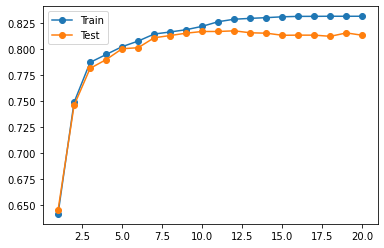

In [54]:
from matplotlib import pyplot
from sklearn.metrics import accuracy_score

#reference: https://machinelearningmastery.com/overfitting-machine-learning-models/

values = [i for i in range(1, 21)]
train_scores, test_scores = list(), list()

for i in values:
  model = RandomForestClassifier(max_depth=i)
  model.fit(X_train, Y_train)

  train_Yhat = model.predict(X_train)
  train_acc = accuracy_score(Y_train, train_Yhat)
  train_scores.append(train_acc)

  test_Yhat = model.predict(X_test)
  test_acc = accuracy_score(Y_test, test_Yhat)
  test_scores.append(test_acc)

pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

#Prediction on the test set (random forest)

In [55]:
from sklearn.datasets import make_classification

y_preds = classifier.predict(cases_data)

In [56]:
import csv

def create_submission_file(y_preds, file_name):
  with open(f'./drive/My Drive/CMPT459/{file_name}', 'w') as csvfile:
    wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
    wr.writerow(["Id", "Prediction"])
    for i, pred in enumerate(y_preds):
      wr.writerow([str(i), str(pred)])

create_submission_file(y_preds, 'submission_randomforest.csv')






#1.4 Building models and hyperparameter tuning (decision trees)

Decision Trees:

In [57]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split 

from sklearn import metrics

#reference: https://www.datacamp.com/community/tutorials/decision-tree-classification-python

#columns = train_data_oversample[['age', 'sex', 'country', 'chronic_disease_binary', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Incident_Rate', 'Case_Fatality_Ratio']]
columns = train_data_oversample[['age', 'sex', 'country', 'chronic_disease_binary', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Incident_Rate', 'Case_Fatality_Ratio']]

mylabel = train_data_oversample['outcome_group']

myX_train, myX_test, myy_train, myy_test = train_test_split(columns, mylabel, test_size=0.2, random_state=1) 

In [58]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(myX_train,myy_train)

#Predict the response for test dataset
y_pred = clf.predict(myX_test)

In [59]:
print("Accuracy:",metrics.accuracy_score(myy_test, y_pred))

Accuracy: 0.8152297042164883


K-Fold Cross-Validation: (decision trees)

In [60]:
from sklearn.model_selection import GridSearchCV
#'max_depth': [5, 10, 20],'min_samples_leaf': [20, 50, 100],
params = {
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [20, 50],
    'criterion': ["gini"]
}

grid_search = GridSearchCV(estimator=clf, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "f1")
%time
grid_search.fit(myX_train, myy_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
Fitting 4 folds for each of 6 candidates, totalling 24 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [5, 10, 20],
                         'min_samples_leaf': [20, 50]},
             scoring='f1', verbose=1)

In [61]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=5, min_samples_leaf=20)

In [62]:
from sklearn.metrics import classification_report
dt_best = grid_search.best_estimator_
print(classification_report(myy_test, dt_best.predict(myX_test)))
#evaluate_model(dt_best)

              precision    recall  f1-score   support

           0       0.70      0.73      0.71      2597
           1       0.87      0.92      0.89      2674
           2       0.82      0.74      0.78      2674

    accuracy                           0.80      7945
   macro avg       0.80      0.80      0.80      7945
weighted avg       0.80      0.80      0.80      7945



In [63]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score

#reference: https://stackabuse.com/cross-validation-and-grid-search-for-model-selection-in-python/

kfold = KFold(n_splits=5, shuffle=True, random_state=73)
f1 = make_scorer(f1_score, average='macro')

accuracies = cross_val_score(estimator=clf, X=myX_train, y=myy_train, scoring=f1, cv=5)     #k

print('mean f1 score:', accuracies.mean())

mean f1 score: 0.8138319483528182


#Overfitting (decision trees)

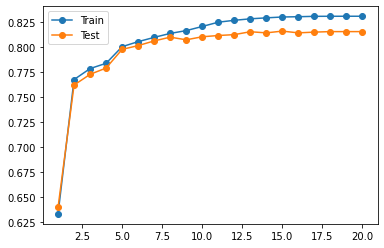

In [64]:
from matplotlib import pyplot
from sklearn.metrics import accuracy_score

#reference: https://machinelearningmastery.com/overfitting-machine-learning-models/

values = [i for i in range(1, 21)]
train_scores, test_scores = list(), list()

for i in values:
  model = DecisionTreeClassifier(max_depth=i)
  model.fit(myX_train, myy_train)

  train_Yhat = model.predict(myX_train)
  train_acc = accuracy_score(myy_train, train_Yhat)
  train_scores.append(train_acc)

  test_Yhat = model.predict(myX_test)
  test_acc = accuracy_score(myy_test, test_Yhat)
  test_scores.append(test_acc)

pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

#Prediction on Test Set (decision trees):

In [65]:
#This code is not used as the random forest scored better.
from sklearn.tree import DecisionTreeClassifier

columns = train_data_oversample[['age', 'sex', 'country', 'chronic_disease_binary', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Incident_Rate', 'Case_Fatality_Ratio']]
mylabel = train_data_oversample['outcome_group']
myX_train, myX_test, myy_train, myy_test = train_test_split(columns, mylabel, test_size=0.2, random_state=1) 
clf = DecisionTreeClassifier(max_depth=20, min_samples_leaf=20, criterion='gini')
clf = clf.fit(myX_train,myy_train)
y_pred = clf.predict(cases_data)


In [66]:
#This code is not used as the random forest scored better.
def create_submission_file(y_preds, file_name):
  with open(f'./drive/My Drive/CMPT459/{file_name}', 'w') as csvfile:
    wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
    wr.writerow(["Id", "Prediction"])
    for i, pred in enumerate(y_preds):
      wr.writerow([str(i), str(pred)])

create_submission_file(y_pred, 'submission_DecisionTree.csv')

